In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("../data/processed")

games = pd.read_csv(DATA_DIR / "games.csv")
moves = pd.read_csv(DATA_DIR / "moves.csv")

print(games.shape)
print(moves.shape)

games = games[games["result"].isin(["1-0","0-1","1/2-1/2"])]

games.head()

(638, 17)
(60068, 7)


,game_id,event,site,date,round,white,black,result,white_elo,black_elo,white_fide_id,black_fide_id,eco,opening,ply_count,game_url,broadcast_url
0,4289e6bd-ea9a-43b6-91e4-3152355ced17,FIDE Grand Swiss 2025,https://lichess.org/broadcast/fide-grand-swiss...,2025.08.26,1.1,"Xiong, Jeffery",Praggnanandhaa R,1/2-1/2,2640,2785,2047640,25059530,C01,French Defense: Exchange Variation,61,https://lichess.org/broadcast/fide-grand-swiss...,https://lichess.org/broadcast/fide-grand-swiss...
1,c64848bf-b984-4282-a458-77aabb7e2956,FIDE Grand Swiss 2025,https://lichess.org/broadcast/fide-grand-swiss...,2025.09.04,1.2,Erigaisi Arjun,"Chigaev, Maksim",1/2-1/2,2771,2638,35009192,4108116,A29,"English Opening: King's English Variation, Fou...",107,https://lichess.org/broadcast/fide-grand-swiss...,https://lichess.org/broadcast/fide-grand-swiss...
2,ed0cee69-c83f-483d-8ed5-54dbc913347b,FIDE Grand Swiss 2025,https://lichess.org/broadcast/fide-grand-swiss...,2025.09.04,1.3,"Bacrot, Etienne",Gukesh D,0-1,2637,2767,605506,46616543,B12,"Caro-Kann Defense: Advance Variation, Short Va...",90,https://lichess.org/broadcast/fide-grand-swiss...,https://lichess.org/broadcast/fide-grand-swiss...
3,8ef97e3b-af9e-440c-832a-0cd1ca787763,FIDE Grand Swiss 2025,https://lichess.org/broadcast/fide-grand-swiss...,2025.09.04,1.4,"Firouzja, Alireza","Amin, Bassem",1-0,2754,2636,12573981,10601457,E92,"King's Indian Defense: Petrosian Variation, St...",130,https://lichess.org/broadcast/fide-grand-swiss...,https://lichess.org/broadcast/fide-grand-swiss...
4,bd03a4e0-8a1f-4634-9882-b3e6717d7f58,FIDE Grand Swiss 2025,https://lichess.org/broadcast/fide-grand-swiss...,2025.09.04,1.5,"Gurel, Ediz","Keymer, Vincent",1/2-1/2,2631,2751,44507356,12940690,C69,"Ruy Lopez: Exchange Variation, Normal Variation",71,https://lichess.org/broadcast/fide-grand-swiss...,https://lichess.org/broadcast/fide-grand-swiss...


Results (%):
result
1/2-1/2    54.9
1-0        27.9
0-1        16.9
*           0.3
Name: proportion, dtype: float64


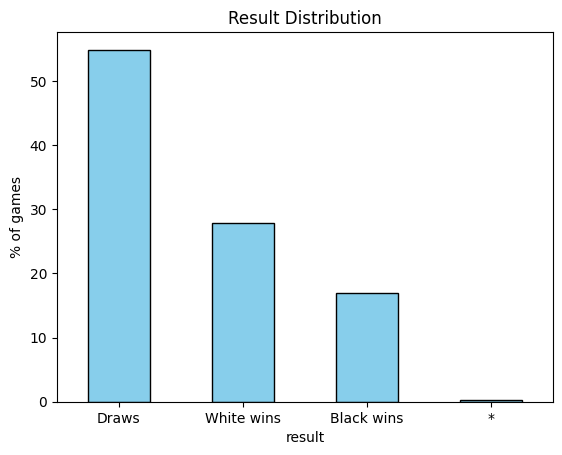

In [46]:
# 1. Result Distribution

results = games["result"].value_counts(normalize=True) * 100
print("Results (%):")
print(results.round(1))

ax = results.plot(
    kind="bar",
    title="Result Distribution",
    color="skyblue",
    edgecolor="k"
)

ax.set_ylabel("% of games")
label_map = {"1-0": "White wins", "0-1": "Black wins", "1/2-1/2": "Draws"}
ax.set_xticklabels([label_map.get(lbl, lbl) for lbl in results.index], rotation=0)

plt.show()

Top 10 Openings:
opening
Sicilian Defense: Nyezhmetdinov-Rossolimo Attack                     18
Italian Game: Two Knights Defense, Modern Bishop's Opening           18
Queen's Gambit Declined: Exchange Variation, Positional Variation    16
Ruy Lopez: Berlin Defense                                            12
Sicilian Defense: Moscow Variation, Main Line                        12
Catalan Opening: Closed                                              11
Catalan Opening: Open Defense, Classical Line                        10
King's Indian Attack                                                  9
Sicilian Defense: Najdorf Variation                                   9
Petrov's Defense: Classical Attack, Staunton Variation                7
Name: count, dtype: int64


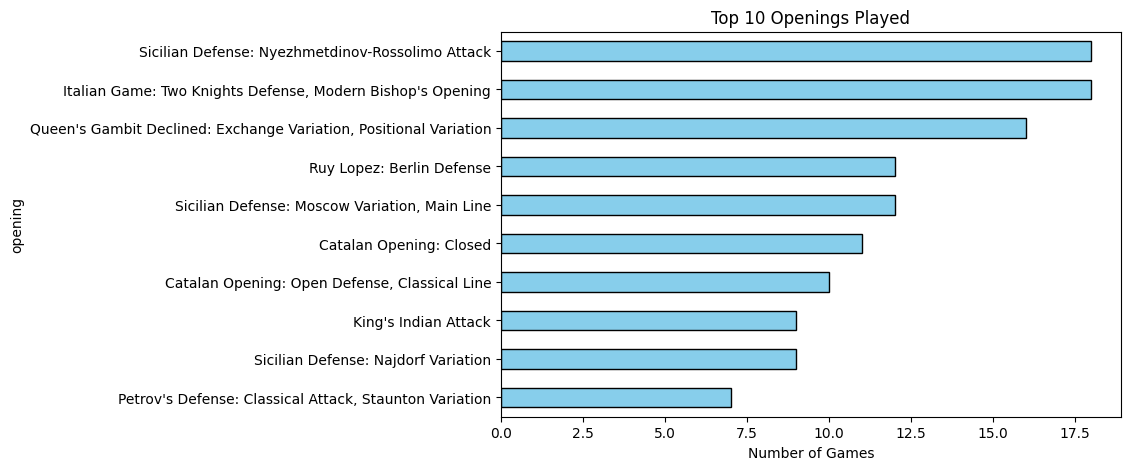

In [47]:
# 2. Top 10 most played openings

top_openings = games["opening"].value_counts().head(10)
print("Top 10 Openings:")
print(top_openings)

ax = top_openings.plot(
    kind="barh",
    figsize=(8,5),
    color="skyblue",
    edgecolor="k"
)

ax.set_title("Top 10 Openings Played")
ax.set_xlabel("Number of Games")
ax.invert_yaxis()   # so most played is at the top
plt.show()

white
Murzin, Volodar        1
Matlakov, Maxim        2
Narayanan S L          4
Suleymanli, Aydin      5
Cheparinov, Ivan       5
Gelfand, Boris         6
Ponomariov, Ruslan     6
Deac, Bogdan-Daniel    6
Hakobyan, Aram         7
Niemann, Hans Moke     7
Name: blunder, dtype: int64


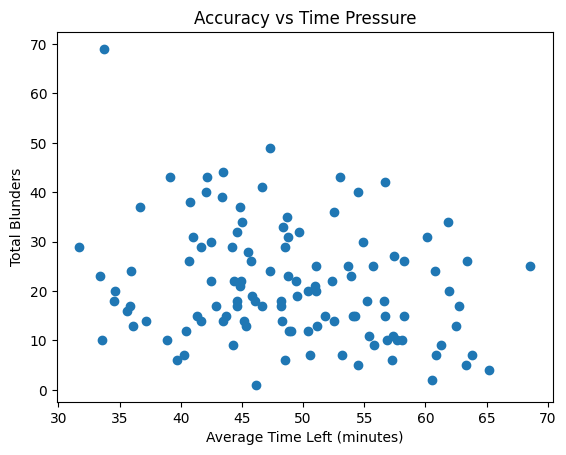

In [48]:
# 3. Most accurate players under time scramble

# Eval swings per move
moves["eval_change"] = moves.groupby("game_id")["eval"].diff().abs()

# Blunder = eval swing > 1.5
moves["blunder"] = moves["eval_change"] > 1.5

# Merge player names
merged = moves.merge(
    games[["game_id", "white", "black"]],
    on="game_id"
)

# Count blunders per player
player_blunders = (
    merged.groupby("white")["blunder"].sum()
    + merged.groupby("black")["blunder"].sum()
).sort_values()

print(player_blunders.head(10))

# Convert clock (H:M:S) to seconds
def to_seconds(c):
    if pd.isna(c): return None
    parts = list(map(int, c.split(":")))
    return parts[0]*3600 + parts[1]*60 + parts[2]

merged["clock_sec"] = merged["clock"].dropna().map(to_seconds)

avg_clock = merged.groupby(["white"])["clock_sec"].mean().dropna()
blunders = player_blunders.reindex(avg_clock.index)

plt.scatter(avg_clock/60, blunders)
plt.xlabel("Average Time Left (minutes)")
plt.ylabel("Total Blunders")
plt.title("Accuracy vs Time Pressure")
plt.show()

     round                   white  white_elo            black  black_elo  \
230   4.57            Amin, Bassem       2636   Divya Deshmukh       2478   
235   5.40       Mishra, Abhimanyu       2611         Gukesh D       2767   
404   7.57          Divya Deshmukh       2478    Ivic, Velimir       2630   
445   8.40  Abdisalimov, Abdimalik       2488  Svane, Frederik       2643   
485   9.22          Aronian, Levon       2744   Woodward, Andy       2557   

    result                                            opening  
230    0-1   Sicilian Defense: Nyezhmetdinov-Rossolimo Attack  
235    1-0            Italian Game: Giuoco Pianissimo, Normal  
404    1-0  Sicilian Defense: French Variation, Westerinen...  
445    1-0                 Ruy Lopez: Closed, Smyslov Defense  
485    0-1            Nimzo-Indian Defense: Sämisch Variation  


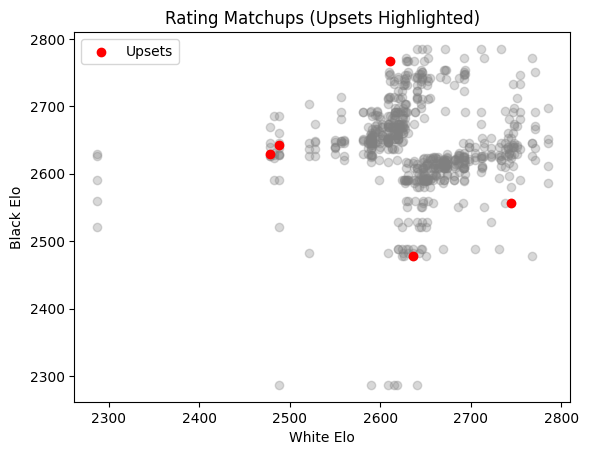

In [49]:
# 4. Giant-Killer Upsets (2600s beating 2750+)

games["elo_diff"] = games["white_elo"] - games["black_elo"]
games["winner"] = games["result"].map({"1-0":"white", "0-1":"black", "1/2-1/2":"draw"})

upsets = games[
    ((games["winner"]=="white") & (games["white_elo"] < games["black_elo"])) |
    ((games["winner"]=="black") & (games["black_elo"] < games["white_elo"]))
]

giant_killers = upsets[abs(upsets["elo_diff"]) >= 150]

print(giant_killers[["round","white","white_elo","black","black_elo","result","opening"]])

plt.scatter(games["white_elo"], games["black_elo"], alpha=0.3, c="grey")
plt.scatter(giant_killers["white_elo"], giant_killers["black_elo"], c="red", label="Upsets")
plt.xlabel("White Elo")
plt.ylabel("Black Elo")
plt.title("Rating Matchups (Upsets Highlighted)")
plt.legend()
plt.show()

Average game length: 46.722834645669295
Median game length: 42.0

Shortest decisive game:
     round               white                      black result  \
579  10.58  Hammer, Jon Ludvig  Olisa, Tennyson Ewomazino    1-0   

                                               opening  moves  \
579  Queen's Indian Defense: Fianchetto Variation, ...     20   

                                              game_url  
579  https://lichess.org/broadcast/fide-grand-swiss...  

Longest decisive game:
     round            white                 black result  \
300   6.11  Keymer, Vincent  Hovhannisyan, Robert    1-0   

                                     opening  moves  \
300  King's Indian Attack: Double Fianchetto    113   

                                              game_url  
300  https://lichess.org/broadcast/fide-grand-swiss...  

Longest game overall (including draws):
     round                   white                 black   result  \
237    5.6  Abdusattorov, Nodirbek  Erdogmus, Ya

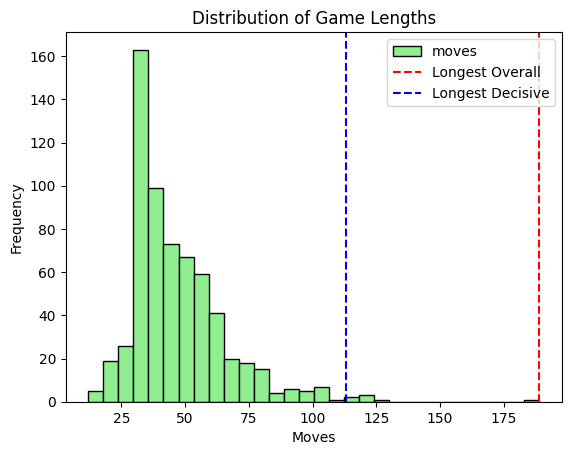

In [51]:
# 5. Game Lengths: Short Tactical Blows vs Marathon Grinds

# Moves column
games["moves"] = games["ply_count"] // 2

# Filter finished games only (ignore walkovers & *)
finished = games[games["result"].isin(["1-0","0-1","1/2-1/2"])]
finished = finished[finished["moves"] > 0]

# Summary
print("Average game length:", finished["moves"].mean())
print("Median game length:", finished["moves"].median())

# Shortest decisive (ignore draws)
shortest_decisive = (
    finished.loc[finished["result"]!="1/2-1/2"]
    .sort_values("moves")
    .head(1)
)
print("\nShortest decisive game:")
print(shortest_decisive[["round","white","black","result","opening","moves","game_url"]])

# Longest decisive (win/loss only)
longest_decisive = (
    finished.loc[finished["result"]!="1/2-1/2"]
    .sort_values("moves", ascending=False)
    .head(1)
)
print("\nLongest decisive game:")
print(longest_decisive[["round","white","black","result","opening","moves","game_url"]])

# Longest overall (including draws)
longest_overall = finished.sort_values("moves", ascending=False).head(1)
print("\nLongest game overall (including draws):")
print(longest_overall[["round","white","black","result","opening","moves","game_url"]])

# Plot
ax = finished["moves"].plot(
    kind="hist", 
    bins=30, 
    color="lightgreen", 
    edgecolor="k"
)
plt.title("Distribution of Game Lengths")
plt.xlabel("Moves")

# Highlight longest overall on histogram
plt.axvline(longest_overall["moves"].values[0], color="red", linestyle="--", label="Longest Overall")
plt.axvline(longest_decisive["moves"].values[0], color="blue", linestyle="--", label="Longest Decisive")
plt.legend()
plt.show()
